In [132]:
import pandas as pd
import re
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 322
!pip freeze > requirements.txt

#импортировали исходные данные
df = pd.read_csv('main_task.csv')
df_kaggle = pd.read_csv('kaggle_task.csv')
sample_sumbission = pd.read_csv('sample_submission.csv')
df['sample'] = 1 # помечаем где у нас трейн
df_kaggle['sample'] = 0 # помечаем где у нас тест
df_kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_kaggle.append(df, sort=False).reset_index(drop=True) # объединяем

data
df = data
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [133]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [134]:
#функции обработки

#считаем % пропусков по каждому признаку
#функция missing_data(data) будет принимать на вход датасет, и определять % пропусков и тип данных
def missing_data(data):
    for i in data.columns:
        md = 100-data[i].isna().value_counts()[0]*100/len(data[i])
        print('% пропусков в',i, md)
    return

#функция конвертации строковых данных в столбце Price Range, на фход идет серия, на выходе числовые значения 
#ghbpyfrf ценовой категории
def price_cat(data):
    if data == '$':
        return 1
    elif data == '$$ - $$$':
        return 2
    elif data == '$$$$':
        return 3

#функция которая получает на вход серию со списком всех кухонь и убирает аартефакты в названиях,
#формируя список 
def resplit(ct):
    ct = ct.replace(", ",'')
    ct = ct.replace("[",'')
    ct = ct.replace("]",'')
    ct = re.split("'(.*?)'",ct)
    ct = list(filter(None, ct))
    return ct

#функция разбивки типов кухонь , нужная для выполенния заданий в модуле
def split_cuisine(ct):
    if re.findall(r"'(.*?)'", ct) == 'Unknown':
        return 'Unknown'
    else:
        return  re.findall(r"'(.*?)'", ct)

#простая функция длинны списка
def len_list(data):
    return len(data)


# функиця разделения даты из отзывов
# тип данных строка, визуально похожая на списки
# необходимо разпарсить данные
# кроме того , в строке есть дата отзыва, ее тоже надо достать
# кол-во дат будет равно кол-ву отзывов

def split_date(ct):
    if re.findall(r'\d\d/\d\d/\d{4}', ct) == 'None':
        return dt.datetime(1900,12,31)
    else:
        return  re.findall(r'\d\d/\d\d/\d{4}', ct)
    
# функция возвращает разницу между первым и последним отзывом в формате datetime
def deltadays(rd):
    if len(rd)>=2:
        a = dt.datetime.strptime(rd[0], '%m/%d/%Y') - dt.datetime.strptime(rd[len(rd)-1], '%m/%d/%Y')
        return a
    else:
        return dt.timedelta(0)

def learn_fit(df, random_state = None):
    #X - данные о ресторанах, Y - целевая переменная
    X = df.drop(['Rating', 'Restaurant_id'], axis = 1)
    y = df['Rating']
    
    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
    #создаем модель
    regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
    #обучение на тесте
    regr.fit(X_train, y_train)
    
    #используем полученную (обученную модель) для предсказания рейтинга в тестовой сборке
    #полученное значение пишем в отдульную переменную
    y_predict = regr.predict(X_test)
    
    #сравниваем предсказанное значение y_predict с тестовым y_test
    print('MAE Regression:', metrics.mean_absolute_error(y_test,y_predict))
    print('MAE Regression round state:', metrics.mean_absolute_error(y_test,np.round(y_predict*2)/2))
    
    #классификация
    le = LabelEncoder()
    le.fit(y_train)
    classif = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_SEED, n_jobs=-1)
    classif.fit(X_train, le.transform(y_train))
    y_predict = classif.predict(X_test)
    print('MAE Классификация:', metrics.mean_absolute_error(y_test,le.inverse_transform(y_predict)))
    
    plt.rcParams['figure.figsize'] = (10,10)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')

In [135]:
missing_data(df)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 34.721999999999994
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0


In [136]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.34551783170533173
MAE Regression round state: 0.33384615384615385
MAE Классификация: 0.3828632478632479


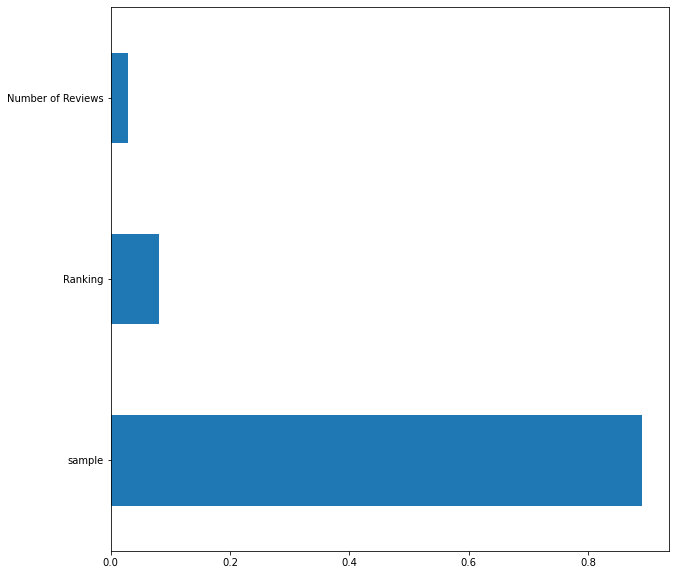

In [137]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [138]:
#удаляем признак как не влияющий на качество 

#df.drop(columns=['ID_TA'], inplace=True)
#df_kaggle.drop(columns=['ID_TA'], inplace=True)


In [139]:
# City

df.groupby('City').Rating.agg(['mean','std','count']).sort_values(by=['mean'], ascending=False)

,mean,std,count
City,,,
Athens,3.423325,1.734354,776
Rome,3.395326,1.730001,2589
Ljubljana,3.389640,1.664843,222
Oporto,3.338785,1.757784,642
Krakow,3.315884,1.756785,554
Vienna,3.295218,1.703231,1443
Berlin,3.285952,1.757230,2705
Edinburgh,3.270470,1.743363,745
Amsterdam,3.270044,1.753022,1372


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,1
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,1


Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.323343432030932
MAE Regression round state: 0.31017094017094016
MAE Классификация: 0.35341880341880344


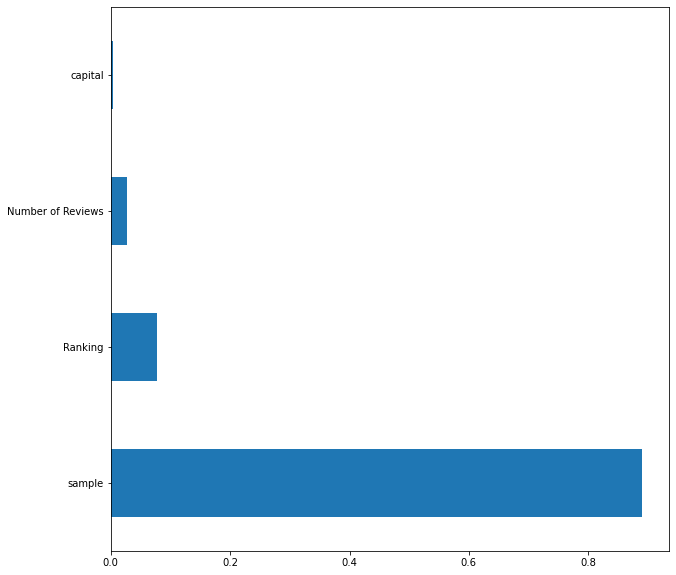

In [140]:
#импортируем данные по городам мира, и заберем оттуда только столицы (признак primary)
cities = pd.read_csv('worldcities.csv')
cities = cities[cities['capital']=='primary']

#уберем ненужную информацию и сформируем список столиц мира, хотя нам надо только европу, но все же
cities.drop(['city_ascii', 'lat','lng','capital','id','admin_name'], inplace=True, axis=1)
cities_list=list(cities['city'])

#вводим новый признак Столица, 1 если город столичный, 0 если не столичный
df['capital']=df['City'].apply(lambda x: 1 if x in cities_list else 0 )
df_kaggle['capital']=df['City'].apply(lambda x: 1 if x in cities_list else 0 )
display(df)

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [141]:
#попробуем добавить численность населения
city_list=df['City'].unique()
city_list={'Paris':2.148, 'Stockholm':0.975, 'London':8.961, 'Berlin':3.669, 'Munich':1.488, 'Oporto':0.287,
       'Milan':1.1399, 'Bratislava':0.428, 'Vienna':1.921, 'Rome':2.790, 'Barcelona':1.664, 'Madrid':3.334,
       'Dublin':1.173, 'Brussels':1.212, 'Zurich':0.434, 'Warsaw':1.793, 'Budapest':1.750, 'Copenhagen':0.794,
       'Amsterdam':0.860, 'Lyon':0.518, 'Hamburg':1.845, 'Lisbon':0.506, 'Prague':1.335, 'Oslo':0.693,
       'Helsinki':0.655, 'Edinburgh':0.488, 'Geneva':0.201, 'Ljubljana':0.286, 'Athens':0.664,
       'Luxembourg':0.644, 'Krakow':0.779}
df['population'] = df.City.replace(to_replace=city_list)
#df_kaggle['population'] = df.City.replace(to_replace=city_list)


In [142]:
#проверяем модель

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18134871794871793
MAE Regression round state: 0.16042735042735043
MAE Классификация: 0.18012820512820513


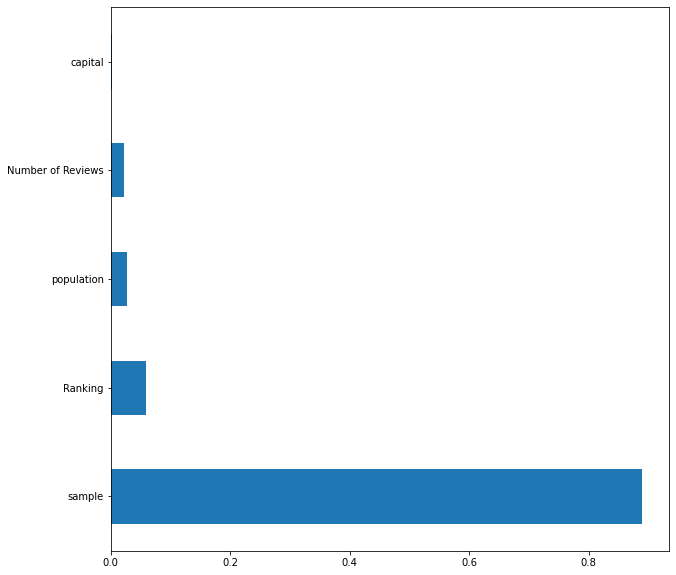

In [143]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [52]:
#Отлично!!! модель улучшена в 2 раза, играем дальше


Модубльное значение для категории Price Range 0    $$ - $$$
dtype: object


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital
6003,id_6003,Stockholm,NaN,1244.0,2.0,11.0,"[['Nice place but rude stuff', 'Delicious Swed...",/Restaurant_Review-g189852-d7118379-Reviews-Wi...,d7118379,0,0,1
8784,id_8784,Prague,['Cafe'],1784.0,2.0,9.0,"[['Pleasant', 'great taste'], ['07/01/2017', '...",/Restaurant_Review-g274707-d7123565-Reviews-Pa...,d7123565,0,0,1
4004,id_4004,Brussels,"['Asian', 'Tibetan', 'Vegetarian Friendly', 'V...",554.0,1.0,79.0,"[['Tibet en Bruxelles!', 'Very decent food'], ...",/Restaurant_Review-g188644-d6433746-Reviews-Mo...,d6433746,0,0,1
1178,id_1178,Paris,NaN,12542.0,2.0,31.0,"[['A corner of Paris', 'Sunday afternoon'], ['...",/Restaurant_Review-g187147-d7816172-Reviews-Le...,d7816172,0,0,1
3160,id_3160,Barcelona,NaN,7003.0,2.0,9.0,"[[], []]",/Restaurant_Review-g187497-d11746173-Reviews-P...,d11746173,0,0,0
9977,id_9977,Barcelona,"['International', 'Spanish', 'Contemporary', '...",4905.0,2.0,41.0,"[['Great tapas, great service!', 'Tasty food a...",/Restaurant_Review-g187497-d10047004-Reviews-L...,d10047004,0,0,0
3107,id_3107,Milan,NaN,3802.0,2.0,41.0,"[['Suggested!!!!!!!!'], ['07/01/2015']]",/Restaurant_Review-g187849-d8291222-Reviews-La...,d8291222,0,0,0
8385,id_8385,Barcelona,"['French', 'Mediterranean', 'European']",2776.0,2.0,155.0,"[['Superb Lunch', 'Excellent food and charming...",/Restaurant_Review-g187497-d2360446-Reviews-La...,d2360446,0,0,0
7639,id_7639,Brussels,"['Belgian', 'Cafe', 'European', 'Vegetarian Fr...",610.0,1.0,67.0,"[['Simple basic cafe', 'Brussels at all hours'...",/Restaurant_Review-g188644-d4102601-Reviews-La...,d4102601,0,0,1
5358,id_5358,Amsterdam,"['Mexican', 'Fast Food', 'Vegetarian Friendly']",2638.0,1.0,18.0,[['Good for a quick fix if you are really hun....,/Restaurant_Review-g188590-d6536958-Reviews-Ta...,d6536958,0,0,1


% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18066965811965813
MAE Regression round state: 0.16004273504273503
MAE Классификация: 0.1838034188034188


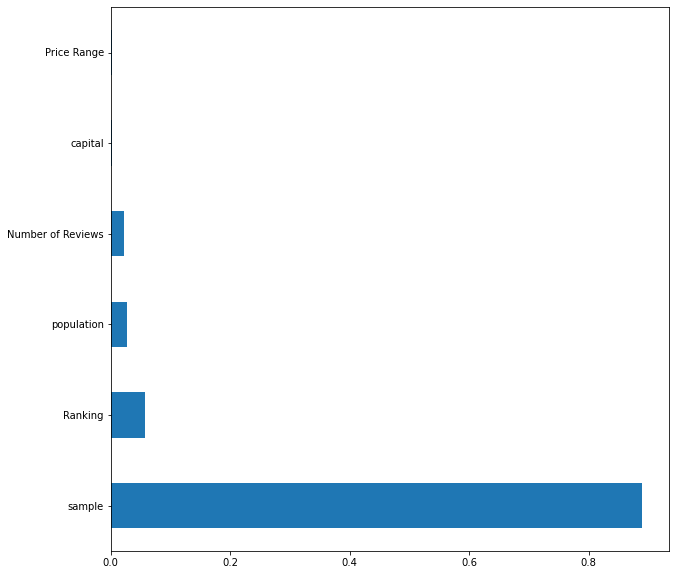

In [144]:
#узнаем модальное значение для категории Price Range
#rjnjhsv позже заполним пропуски
print('Модубльное значение для категории Price Range',df['Price Range'].mode())

df['Price Range'].fillna(2, inplace=True, axis=0)
range_replace={'$':1,'$$ - $$$':2,'$$$$':3}
df['Price Range']=df['Price Range'].replace(to_replace=range_replace)

#делаем тоже самое с кэгл
df_kaggle['Price Range']=df_kaggle['Price Range'].replace(to_replace=range_replace)
df_kaggle['Price Range'].fillna(2, inplace=True, axis=0)

display(df_kaggle.sample(15))
missing_data(df)
#ghjdthztv модель , уже не удаляем столбец Price Range т.к. мы его изменили 
drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [145]:
#ничего не сильно не изменилось, кроме модели с округлением, стало даже чуть хуже
#думаю этот признак можно удалить

In [146]:
price_in_city_dict = df.groupby('City')['Price Range'].mean().to_dict()
df['Price in City'] = df['City'].map(price_in_city_dict)


Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.17832008547008546
MAE Regression round state: 0.1579059829059829
MAE Классификация: 0.17884615384615385


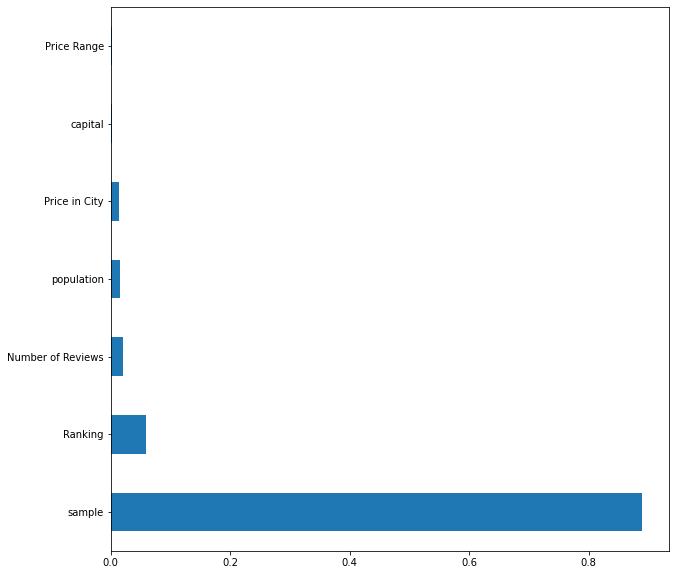

In [147]:


drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [148]:
#Попробуем поиграть с кухнями

#добавили количество кухонь в ресторане
#cuisine = pd.read_csv('cuisine.csv')
#df['col_cuisine'] = cuisine['col_cuisine'].apply(resplit)
#display(df)
#df['col_cuisine'] = df['col_cuisine'].apply(len)

#drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)
#mean_cuisine=df.groupby('City').col_cuisine.agg('mean').to_dict()
#mean_cuisine['Stockholm']
#df['Cuisine Style'] = df['Cuisine Style'].map(mean_cuisine)
#df['Cuisine Style'] = df['City'].replace(to_replace=mean_cuisine)
#df_kaggle['Cuisine Style'] = df['City'].replace(to_replace=mean_cuisine)


#df.sample(15)
#missing_data(df)

#drop_columns = ['City','Number of Reviews', 'URL_TA', 'ID_TA', 'Reviews']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

#модель ухудшилась, убираем этот признак !!! 

In [149]:
df.head(4)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148,1.926981
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,0.655,1.911579
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0.488,1.766443
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,1,8.961,1.861949


In [150]:
#есть небольшое улучшение - изменим и тестовую

#df

#df3=df[['URL_TA','col_cuisine']]

#df4 = pd.merge(df_kaggle, df3, how = 'left')
#display(df4)
#missing_data(df4)
#display(df[df['Restaurant_id']=='id_0'])
#display(df_kaggle[df_kaggle['Restaurant_id']=='id_0'])
#df_kaggle['col_cuisine'] = cuisine['col_cuisine'].apply(resplit)
#df_kaggle['col_cuisine'] = df['col_cuisine'].apply(len)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.17849102564102562
MAE Regression round state: 0.1570940170940171
MAE Классификация: 0.16833333333333333


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City,city_restaurants,ranking_norm
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148,1.926981,6108,2.122299
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,0.655,1.911579,475,0.223158
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0.488,1.766443,745,1.087248


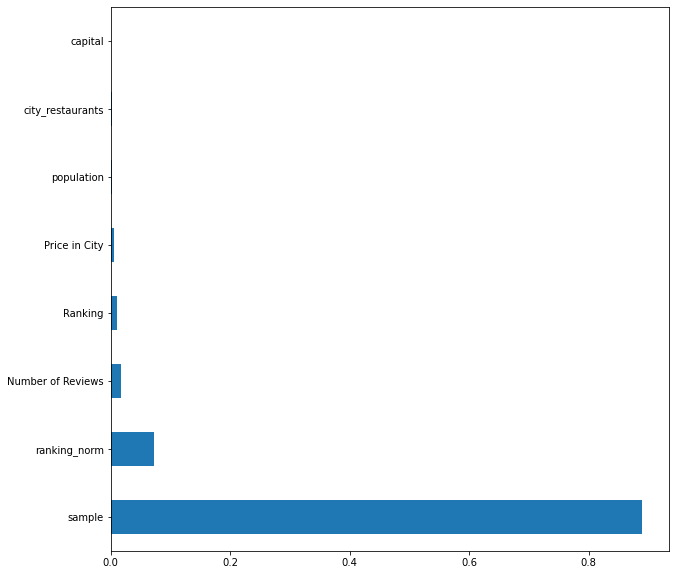

In [151]:
#создадим признак, кол-во ресторанов в городе
per_city_dict = dict(df['City'].value_counts())
per_city_dict
df['city_restaurants'] = df.City.map(per_city_dict)

# Добавим признак - нормализованный ранг ranking_norm
df['ranking_norm'] = df.Ranking / df.city_restaurants

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)
df.head(3)

In [152]:
#отличный результат , повысили еще точность
#сделаем тоже и на kaggle

per_city_dict = dict(df_kaggle['City'].value_counts())
per_city_dict
df_kaggle['city_restaurants'] = df_kaggle.City.map(per_city_dict)
# Добавим признак - нормализованный ранг ranking_norm
df_kaggle['ranking_norm'] = df_kaggle.Ranking / df_kaggle.city_restaurants
df_kaggle.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,city_restaurants,ranking_norm
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0,1,1211,10.704377
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0,1,99,1.070707
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0,0,149,5.436242


In [153]:
#display(df.head(3))
#display(df_kaggle.head(3))







  # ПОПРОБУЕМ еще немного добавить признаков
    
missing_data(df_kaggle)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.069999999999993
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.569999999999993
% пропусков в Reviews 0.01999999999999602
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0


In [154]:
#делаем dummy
display(df.sample(5))
display(df_kaggle.sample(5))
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)
df_kaggle = pd.get_dummies(df_kaggle, columns=[ 'City',], dummy_na=True)


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City,city_restaurants,ranking_norm
43440,id_12925,Paris,NaN,12927.0,2,42.0,"[['Average food, horrible service, too expens....",/Restaurant_Review-g187147-d695248-Reviews-Caf...,d695248,1,3.0,1,2.148,1.926981,6108,2.116405
35615,id_11708,Paris,"['Japanese', 'Sushi']",11710.0,2,8.0,"[['Your local sushi place'], ['08/25/2015']]",/Restaurant_Review-g187147-d4061695-Reviews-ID...,d4061695,1,3.5,1,2.148,1.926981,6108,1.917158
39774,id_16144,London,"['Chinese', 'Asian']",16156.0,2,17.0,[['shockingly poor ....AVOID! (food delivery)'...,/Restaurant_Review-g186338-d5795409-Reviews-Ja...,d5795409,1,1.5,1,8.961,1.861949,7193,2.246073
11657,id_911,Dublin,NaN,913.0,2,8.0,"[['Amazing cakes!!', 'Enjoy at amazing Natural...",/Restaurant_Review-g186605-d12681755-Reviews-T...,d12681755,1,4.5,1,1.173,1.839713,836,1.092105
31939,id_125,Ljubljana,"['Steakhouse', 'Barbecue', 'Argentinean', 'Glu...",126.0,3,125.0,"[['Tasty steak', 'Business Lunch'], ['10/18/20...",/Restaurant_Review-g274873-d782764-Reviews-Arg...,d782764,1,4.0,1,0.286,1.819820,222,0.567568


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,city_restaurants,ranking_norm
2476,id_2476,Bratislava,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",158.0,2.0,40.0,"[['didnt expect such a great quality', 'Very g...",/Restaurant_Review-g274924-d4769768-Reviews-Ri...,d4769768,0,0,1,79,2.000000
9330,id_9330,Barcelona,"['European', 'Wine Bar', 'International', 'Med...",3134.0,2.0,37.0,"[['Holiday night out', 'Can you Spell ""Fantast...",/Restaurant_Review-g187497-d8853377-Reviews-Ra...,d8853377,0,0,0,661,4.741301
1874,id_1874,Rome,['Italian'],5119.0,1.0,41.0,"[['No frills eatery'], ['09/07/2017']]",/Restaurant_Review-g187791-d4080987-Reviews-Co...,d4080987,0,0,1,511,10.017613
820,id_820,Lisbon,"['Mediterranean', 'European', 'Portuguese', 'V...",809.0,2.0,84.0,"[['Unpretentious', 'nice place for lunch or di...",/Restaurant_Review-g189158-d9796702-Reviews-La...,d9796702,0,0,1,347,2.331412
6902,id_6902,Athens,['Greek'],1017.0,2.0,NaN,"[[], []]",/Restaurant_Review-g189400-d1792283-Reviews-Cr...,d1792283,0,0,1,148,6.871622


Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.177491452991453
MAE Regression round state: 0.15794871794871795
MAE Классификация: 0.1694017094017094


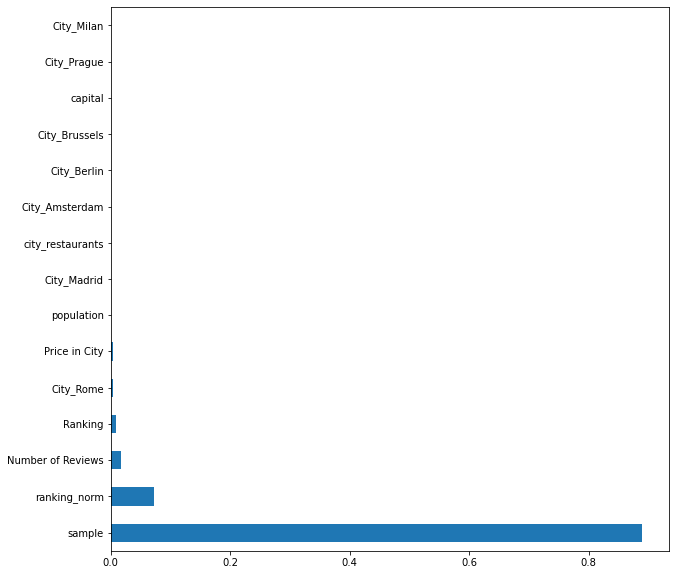

In [156]:
drop_columns = [ 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [26]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df['sample'] = 1 # помечаем где у нас трейн
df_kaggle['sample'] = 0 # помечаем где у нас тест
df_kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df.append(df_kaggle, sort=False).reset_index(drop=True) # объединяем

In [28]:
data.head(3)

,Restaurant_id,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,capital,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,sample
0,id_5569,"['European', 'French', 'International']",5570.0,3.5,2.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,...,0,1,0,0,0,0,0,0,0,1
1,id_1535,NaN,1537.0,4.0,2.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,...,0,0,0,0,1,0,0,0,0,1
2,id_352,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,3.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,...,0,0,0,0,0,0,0,0,0,1


In [158]:


data['Number of Reviews'] = data['Number of Reviews'].fillna(0)
data
drop_columns = ['Restaurant_id','City', 'Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
data.drop(columns = drop_columns, inplace=True)
df_preproc = data

df_preproc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Price Range        50000 non-null  int64  
 2   Number of Reviews  50000 non-null  float64
 3   sample             50000 non-null  int64  
 4   Rating             50000 non-null  float64
 5   capital            50000 non-null  int64  
 6   population         50000 non-null  float64
 7   Price in City      50000 non-null  float64
 8   city_restaurants   50000 non-null  int64  
 9   ranking_norm       50000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


In [163]:
df_preproc.sample(10)
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Price Range        50000 non-null  int64  
 2   Number of Reviews  50000 non-null  float64
 3   sample             50000 non-null  int64  
 4   Rating             50000 non-null  float64
 5   capital            50000 non-null  int64  
 6   population         50000 non-null  float64
 7   Price in City      50000 non-null  float64
 8   city_restaurants   50000 non-null  int64  
 9   ranking_norm       50000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


In [164]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)


In [170]:

display(train_data.sample(5))
display(test_data.sample(5))
display(y)
display(X)

,Ranking,Price Range,Number of Reviews,Rating,capital,population,Price in City,city_restaurants,ranking_norm
37165,260.0,3,124.0,4.5,1,3.3340,1.916077,3813,0.068188
43420,3203.0,1,8.0,4.5,0,1.6640,1.856259,3395,0.943446
48741,7884.0,2,8.0,5.0,1,8.9610,1.861949,7193,1.096066
28436,67.0,2,137.0,4.5,1,0.4280,1.936842,380,0.176316
28015,5330.0,2,51.0,3.0,0,1.1399,1.845583,2694,1.978471


,Ranking,Price Range,Number of Reviews,Rating,capital,population,Price in City,city_restaurants,ranking_norm
1330,2314.0,2,96.0,0.0,1,1.335,1.840308,1816,1.274229
9481,171.0,2,406.0,0.0,0,0.779,1.763538,554,0.308664
1268,10814.0,2,3.0,0.0,1,8.961,1.861949,7193,1.503406
8803,623.0,1,90.0,0.0,1,1.173,1.839713,836,0.745215
6770,658.0,2,52.0,0.0,1,1.335,1.840308,1816,0.362335


array([3.5, 4. , 4.5, ..., 4.5, 4. , 3. ])

,Ranking,Price Range,Number of Reviews,capital,population,Price in City,city_restaurants,ranking_norm
10000,5570.0,2,194.0,1,2.1480,1.926981,6108,0.911919
10001,1537.0,2,10.0,1,0.9750,1.969022,1033,1.487899
10002,353.0,3,688.0,1,8.9610,1.861949,7193,0.049075
10003,3458.0,2,3.0,1,3.6690,1.862477,2705,1.278373
10004,621.0,2,84.0,0,1.4880,1.944105,1145,0.542358
...,...,...,...,...,...,...,...,...
49995,500.0,2,79.0,0,1.1399,1.845583,2694,0.185598
49996,6341.0,2,542.0,1,2.1480,1.926981,6108,1.038147
49997,1652.0,2,4.0,1,0.9750,1.969022,1033,1.599226
49998,641.0,2,70.0,1,1.7930,1.886486,925,0.692973


In [188]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [189]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape, y_train.shape

((10000, 8), (40000, 9), (40000, 8), (30000, 8), (10000, 8), (30000,))

In [190]:
#ML

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


y_pred = (y_pred * 2).round()/2


# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


MAE: 0.191


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [191]:
#test_data = test_data.drop(['Rating'], axis=1)


In [192]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.0


In [193]:
#drop_columns = ['City', 'Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(test_data.drop(columns = drop_columns).dropna(), random_state=322)
#test_data

In [194]:
predict_submission = model.predict(test_data)
predict_submission = (predict_submission * 2).round()/2

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [195]:
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4. , 4.5])

In [196]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


In [197]:
df_kaggle

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,id_9995,"['Caribbean', 'Barbecue', 'Jamaican', 'Vegetar...",4367.0,1.0,28.0,[['By far best Chicken burgers and wings in L....,/Restaurant_Review-g186338-d11916827-Reviews-C...,d11916827,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,id_9996,"['Indian', 'Asian', 'Nepali', 'Bangladeshi']",2612.0,2.0,2.0,"[['Ok indian food'], ['11/25/2017']]",/Restaurant_Review-g189158-d12701633-Reviews-C...,d12701633,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,id_9997,NaN,5562.0,2.0,2.0,"[[], []]",/Restaurant_Review-g187849-d13198194-Reviews-Q...,d13198194,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,id_9998,['Italian'],4010.0,2.0,2.0,"[[], []]",/Restaurant_Review-g187849-d3862815-Reviews-La...,d3862815,0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
df

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,0,0,1,0,0,0,0,0,0,0
49997,id_1649,"['Japanese', 'Sushi']",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,0,0,1,0,0,0,0
49998,id_640,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,0,0,0,0,1,0,0
